# MBTI Prediction - Strategy 2
In this notebook, we will train a classification model for each category and not only one to directly predict the full MBTI type.

## Libraries

In [17]:
from itertools import islice 
from joblib import dump, load
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

## Data import

In [2]:
df = pd.read_csv('../mbti_data.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
df.shape

(8675, 2)

## Data preprocessing

Split each line (~50 posts) into subline (25 posts).

In [4]:
def dataframe_split(df, n=25):
    df_r = pd.DataFrame(columns=['type','posts'])
    for i in range(len(df)):
        full_list = df.loc[i, 'posts'].split('|||')
        sub_list = [full_list[i:i+n] for i in range(0, len(full_list),n)]
        for j in sub_list:
            df_r = df_r.append({'type': df.loc[i, 'type'], 'posts': ' '.join(j)}, ignore_index=True)
    return df_r

In [5]:
%%time
df = dataframe_split(df)

Wall time: 35 s


In [6]:
df.shape

(17318, 2)

We prepare our targets. We will have one classifier to predict the "target_ie" value, one for "target_sn", one for "target_tf" and one for "target_jp".

In [7]:
df['target_ie'] = df['type'].apply(lambda row: row[0])
df['target_sn'] = df['type'].apply(lambda row: row[1])
df['target_tf'] = df['type'].apply(lambda row: row[2])
df['target_jp'] = df['type'].apply(lambda row: row[3])
df.head()

,type,posts,target_ie,target_sn,target_tf,target_jp
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,I,N,F,J
1,INFJ,"Get high in backyard, roast and eat marshmello...",I,N,F,J
2,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
3,ENTP,Sounds pretty much like my area and what I'm g...,E,N,T,P
4,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P


Let's see the distribition of the new variables created.

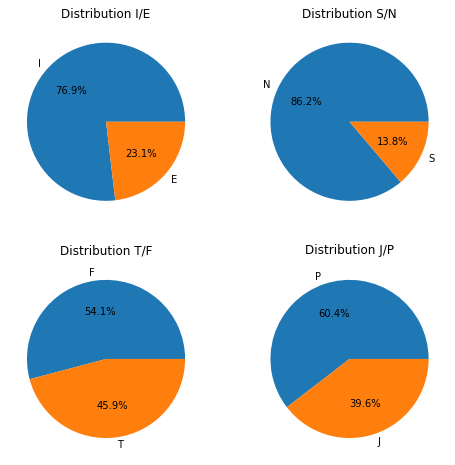

In [8]:
ie_dist = df['target_ie'].value_counts().rename_axis('types').reset_index(name='counts')
sn_dist = df['target_sn'].value_counts().rename_axis('types').reset_index(name='counts')
tf_dist = df['target_tf'].value_counts().rename_axis('types').reset_index(name='counts')
jp_dist = df['target_jp'].value_counts().rename_axis('types').reset_index(name='counts')

fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0, 0].pie(ie_dist['counts'], labels=ie_dist['types'], autopct='%1.1f%%')
axs[0, 0].set_title('Distribution I/E')
axs[0, 1].pie(sn_dist['counts'], labels=sn_dist['types'], autopct='%1.1f%%')
axs[0, 1].set_title('Distribution S/N')
axs[1, 0].pie(tf_dist['counts'], labels=tf_dist['types'], autopct='%1.1f%%')
axs[1, 0].set_title('Distribution T/F')
axs[1, 1].pie(jp_dist['counts'], labels=jp_dist['types'], autopct='%1.1f%%')
axs[1, 1].set_title('Distribution J/P')
plt.show()

F1-score

Let's preprocess the data.

In [9]:
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()

def preprocessing(text, stemming_on=False, stop_words=stop_words, porter_stemmer=porter_stemmer):
    text = text.lower()                                          # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)                  # Noise removal (regex to remove punctuations)
    text = text.strip()                                          # Noise removal (extra spaces)
    words = text.split()                                         # Split sentence into list of words
    words = [w for w in words if not w in stop_words]            # Stopwords removal
    if(stemming_on):
        words = [porter_stemmer.stem(word) for word in words]    # Replace the word by its stem
    text = ' '.join(words)                                       # Transform list of words to str
    return text

In [10]:
%%time
df['posts_preproc'] = df['posts'].apply(lambda row: preprocessing(row, stemming_on=True))

Wall time: 2min


In [11]:
df.head()

,type,posts,target_ie,target_sn,target_tf,target_jp,posts_preproc
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,I,N,F,J,http www youtub com watch v qsxhcwe3krw http 4...
1,INFJ,"Get high in backyard, roast and eat marshmello...",I,N,F,J,get high backyard roast eat marshmellow backya...
2,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,find lack post alarm sex bore posit often exam...
3,ENTP,Sounds pretty much like my area and what I'm g...,E,N,T,P,sound pretti much like area go right tri figur...
4,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one http www youtub com watch v fhigbolff...


## Vectorization

In [12]:
c_vectorizer = CountVectorizer()
ti_vectorizer = TfidfVectorizer()

c_X = c_vectorizer.fit_transform(df['posts_preproc'])
ti_X = ti_vectorizer.fit_transform(df['posts_preproc'])

## Analysis - Best configuration

In [13]:
config = {
    'data_vect': {
        'CountVectorizer': c_X,
        'TfidfVectorizer': ti_X
    },
    'classifier': {
        'LinearSVC': LinearSVC(class_weight='balanced', random_state=14, max_iter=50000), 
        'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=14, max_iter=50000)
    }
}

In [20]:
global_perf_trainings = {
    'target_ie': [],
    'target_sn': [],
    'target_tf': [],
    'target_jp': []
}

In [21]:
def training_analysis(df, config, target):
    perf_trainings = []
    for vectorizer in config['data_vect']:
        X_train, X_test, y_train, y_test = train_test_split(config['data_vect'][vectorizer], df[target], test_size=0.2, random_state=14)
        for classifier in config['classifier']:
            config['classifier'][classifier].fit(X_train, y_train)
            print(f'{vectorizer} | {classifier}:')
            print(f'_________________________\n')
            y_pred = config['classifier'][classifier].predict(X_test)
            perf_trainings.append(f1_score(y_test, y_pred, average='macro'))
            print(f'{classification_report(y_test, y_pred)}\n')
            print(f'--------------------------------------------------------------\n')
    global_perf_trainings[target] = perf_trainings

**Target I/E**

In [22]:
%%time
training_analysis(df, config, 'target_ie')

CountVectorizer | LinearSVC:
_________________________

              precision    recall  f1-score   support

           E       0.52      0.54      0.53       824
           I       0.85      0.84      0.85      2640

    accuracy                           0.77      3464
   macro avg       0.69      0.69      0.69      3464
weighted avg       0.77      0.77      0.77      3464


--------------------------------------------------------------

CountVectorizer | LogisticRegression:
_________________________

              precision    recall  f1-score   support

           E       0.55      0.58      0.57       824
           I       0.87      0.85      0.86      2640

    accuracy                           0.79      3464
   macro avg       0.71      0.72      0.71      3464
weighted avg       0.79      0.79      0.79      3464


--------------------------------------------------------------

TfidfVectorizer | LinearSVC:
_________________________

              precision    recall  f1-s

**Target S/N**

In [24]:
%%time
training_analysis(df, config, 'target_sn')

CountVectorizer | LinearSVC:
_________________________

              precision    recall  f1-score   support

           N       0.91      0.91      0.91      2976
           S       0.45      0.44      0.44       488

    accuracy                           0.85      3464
   macro avg       0.68      0.68      0.68      3464
weighted avg       0.84      0.85      0.84      3464


--------------------------------------------------------------

CountVectorizer | LogisticRegression:
_________________________

              precision    recall  f1-score   support

           N       0.91      0.91      0.91      2976
           S       0.46      0.48      0.47       488

    accuracy                           0.85      3464
   macro avg       0.69      0.69      0.69      3464
weighted avg       0.85      0.85      0.85      3464


--------------------------------------------------------------

TfidfVectorizer | LinearSVC:
_________________________

              precision    recall  f1-s

**Target T/F**

In [25]:
%%time
training_analysis(df, config, 'target_tf')

CountVectorizer | LinearSVC:
_________________________

              precision    recall  f1-score   support

           F       0.78      0.79      0.78      1872
           T       0.75      0.74      0.74      1592

    accuracy                           0.77      3464
   macro avg       0.76      0.76      0.76      3464
weighted avg       0.76      0.77      0.76      3464


--------------------------------------------------------------

CountVectorizer | LogisticRegression:
_________________________

              precision    recall  f1-score   support

           F       0.81      0.79      0.80      1872
           T       0.76      0.78      0.77      1592

    accuracy                           0.78      3464
   macro avg       0.78      0.78      0.78      3464
weighted avg       0.79      0.78      0.78      3464


--------------------------------------------------------------

TfidfVectorizer | LinearSVC:
_________________________

              precision    recall  f1-s

**Target J/P**

In [26]:
%%time
training_analysis(df, config, 'target_jp')

CountVectorizer | LinearSVC:
_________________________

              precision    recall  f1-score   support

           J       0.60      0.60      0.60      1347
           P       0.75      0.74      0.74      2117

    accuracy                           0.69      3464
   macro avg       0.67      0.67      0.67      3464
weighted avg       0.69      0.69      0.69      3464


--------------------------------------------------------------

CountVectorizer | LogisticRegression:
_________________________

              precision    recall  f1-score   support

           J       0.62      0.61      0.61      1347
           P       0.75      0.76      0.76      2117

    accuracy                           0.70      3464
   macro avg       0.69      0.68      0.69      3464
weighted avg       0.70      0.70      0.70      3464


--------------------------------------------------------------

TfidfVectorizer | LinearSVC:
_________________________

              precision    recall  f1-s

**Results visualisation**

In [38]:
config_str = [
    'count-linearsvc', 'count-lr', 'tfidf-linearsvc', 'tfidf-lr'
]

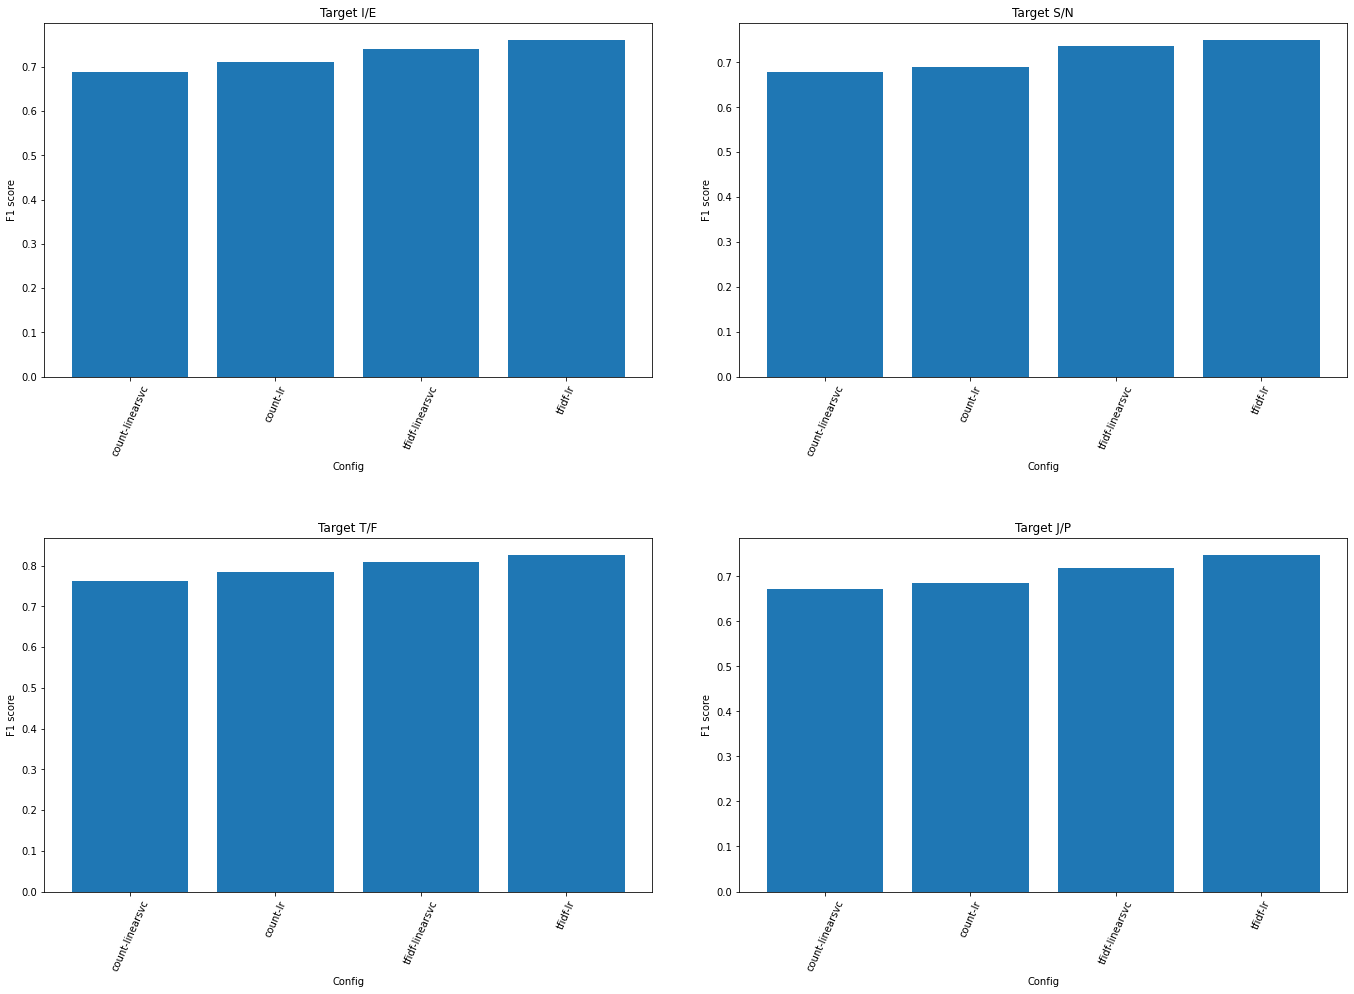

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))

axs[0, 0].bar(range(len(global_perf_trainings['target_ie'])), global_perf_trainings['target_ie'])
axs[0, 0].set_xticks(range(len(config_str)))
axs[0, 0].set_xticklabels(config_str, rotation=66)
axs[0, 0].set_xlabel('Config')
axs[0, 0].set_ylabel('F1 score')
axs[0, 0].set_title('Target I/E')

axs[0, 1].bar(range(len(global_perf_trainings['target_sn'])), global_perf_trainings['target_sn'])
axs[0, 1].set_xticks(range(len(config_str)))
axs[0, 1].set_xticklabels(config_str, rotation=66)
axs[0, 1].set_xlabel('Config')
axs[0, 1].set_ylabel('F1 score')
axs[0, 1].set_title('Target S/N')

axs[1, 0].bar(range(len(global_perf_trainings['target_tf'])), global_perf_trainings['target_tf'])
axs[1, 0].set_xticks(range(len(config_str)))
axs[1, 0].set_xticklabels(config_str, rotation=66)
axs[1, 0].set_xlabel('Config')
axs[1, 0].set_ylabel('F1 score')
axs[1, 0].set_title('Target T/F')

axs[1, 1].bar(range(len(global_perf_trainings['target_jp'])), global_perf_trainings['target_jp'])
axs[1, 1].set_xticks(range(len(config_str)))
axs[1, 1].set_xticklabels(config_str, rotation=66)
axs[1, 1].set_xlabel('Config')
axs[1, 1].set_ylabel('F1 score')
axs[1, 1].set_title('Target J/P')

fig.tight_layout(pad=5)

plt.show()

## Training

### Target I/E

In [ ]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_ie'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_ie'], test_size=0.2, random_state=14)

In [ ]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

In [ ]:
dump(ti_clf, '../models/model_ie.joblib') 

 ### Target S/N

In [ ]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_sn'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_sn'], test_size=0.2, random_state=14)

In [ ]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

In [ ]:
dump(ti_clf, '../models/model_sn.joblib') 

 ### Target T/F

In [ ]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_tf'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_tf'], test_size=0.2, random_state=14)

In [ ]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

In [ ]:
dump(ti_clf, '../models/model_tf.joblib') 

 ### Target J/P

In [ ]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_jp'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_jp'], test_size=0.2, random_state=14)

In [ ]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

In [ ]:
dump(ti_clf, '../models/model_jp.joblib') 

## Prediction

In [ ]:
clf_ie = load('../models/model_ie.joblib')
clf_sn = load('../models/model_sn.joblib')
clf_tf = load('../models/model_tf.joblib')
clf_jp = load('../models/model_jp.joblib')
print('Models loaded!')

In [ ]:
test_string = ['what am I going to do during this lockdown maybe think about a new business']
test_string_vect = ti_vectorizer.transform(test_string)
print(test_string_vect)

In [ ]:
result_ie = clf_ie.predict(test_string_vect)
result_sn = clf_sn.predict(test_string_vect)
result_tf = clf_tf.predict(test_string_vect)
result_jp = clf_jp.predict(test_string_vect)

In [ ]:
print(f'MBTI type: {result_ie[0]}{result_sn[0]}{result_tf[0]}{result_jp[0]}')